# Intel Image Classification with ResNet34

## Final assignment course project for **Deep Learning with PyTorch: Zero to GANs**.

The project work is organised as follows:
1. Collecting Dataset
2. Defining Problem Statement
3. Data Exploration and Cleaning
4. Modeling
5. Evaluation and Prediction
6. Improvement
7. Conclusion and Summary

## Jovian essentials

Including all the jovian commit essentials to save our work on the jovian platform for sharing and for future works.

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
# set a project name for the notebook
project_name = 'course-project'

# Step - 1: Collecting the Dataset

We'll be using a dataset from kaggle. To download and use datasets from kaggle, we need the opendatasets package. So, let's install and import it.  

In [4]:
!pip install opendatasets --upgrade --quiet

I have chosen the Intel Image Classification Dataset. Let us download it and get started. Kaggle will prompt us to enter our username and an API key which we can get from our kaggle profile.

In [5]:
import opendatasets as od
od.download('https://www.kaggle.com/puneet6060/intel-image-classification')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lavanyask
Your Kaggle Key: ··········


  7%|▋         | 23.0M/346M [00:00<00:01, 237MB/s]

100%|██████████| 346M/346M [00:01<00:00, 188MB/s]


Cool! the dataset is downloaded. Let's move on to the next step.

## Importing all libraries

In [6]:
# for file operations
import os
# for random sampling
import random
# to work with dataframes
import pandas as pd

In [7]:
# pytorch module
import torch
import torchvision
# for train, valid and test split
from torch.utils.data import random_split


In [8]:
# to create datasets from folders
from torchvision.datasets import ImageFolder
# to convert images to pytorch tensors
from torchvision.transforms import ToTensor
# to perform augmentations
import torchvision.transforms as tt

In [9]:
# for loading data in batches
from torch.utils.data.dataloader import DataLoader

In [10]:
# create a grid of images
from torchvision.utils import make_grid

In [11]:
# for creating sequential network architecture
import torch.nn as nn
import torch.nn.functional as F
# to use pretrained models
from torchvision import models

In [12]:
# for plotting images and graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# set white facecolor
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [13]:
# to load images from image path names
from PIL import Image

In [14]:
# set seed
def seed_all(seed = 2020):
    print("Seed: {}".format(seed))
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)

seed_all(2020)

Seed: 2020


# Step - 2: Defining Problem Statement

## Intel Image Classification
The dataset was initially created by Intel for an image classification contest. It is an expansive image dataset consisting of approximately 25,000 images. The images are divided into the following categories: buildings, forest, glacier, mountain, sea, and street. Our task is to train a model using PyTorch to classify the image as one of the 6 categories.

# Step - 3: Data Exploration and Cleaning

Let's quickly set up some directory paths to use later in the project and also take a look at the file structure.

If the dataset was downloaded as a zipfile or tarfile, we need to extract it.

In [15]:
ROOT_DIR = './intel-image-classification/'
TRAIN_DIR = './intel-image-classification/seg_train/seg_train/'
TEST_DIR = './intel-image-classification/seg_test/seg_test/'
PRED_DIR = './intel-image-classification/seg_pred/seg_pred/'

In [16]:
os.listdir(ROOT_DIR)

['seg_pred', 'seg_train', 'seg_test']

In [17]:
print("TRAIN_DIR:",os.listdir(TRAIN_DIR))
i = 0
for d in os.listdir(TRAIN_DIR):
  i += len(os.listdir(TRAIN_DIR + d))
print("Number of images for training:",i)

print("TEST_DIR:",os.listdir(TEST_DIR))
i = 0
for d in os.listdir(TEST_DIR):
  i += len(os.listdir(TEST_DIR + d))
print("Number of images for validation:",i)

print("Number of images to be predicted:",len(os.listdir(PRED_DIR)))

TRAIN_DIR: ['mountain', 'sea', 'street', 'buildings', 'glacier', 'forest']
Number of images for training: 14034
TEST_DIR: ['mountain', 'sea', 'street', 'buildings', 'glacier', 'forest']
Number of images for validation: 3000
Number of images to be predicted: 7301


Okay after having a look at the dataset, we can observe that: 
* We have three main folders one each for - training, testing and to make predictions.
* The images are divided into 6 categories: buildings, forest, glacier, mountain, sea and street.
* There are around 14000 images for training.
* There are around 3000 images for validating.
* There are around 7000 images for which class is to be predicted.

We will be resizing the images to (128,128) and also tranforming them to tensors. We will also perform some augmentations.

In [18]:
# Data transforms
train_transforms = tt.Compose([tt.Resize((128,128)),
                               tt.RandomHorizontalFlip(), 
                               tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                               tt.ToTensor()])
valid_transforms = tt.Compose([tt.Resize((128,128)),
                               tt.ToTensor()])

In [19]:
dataset = ImageFolder(TRAIN_DIR, transform = train_transforms)

In [20]:
print(dataset.classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [21]:
# getting the first observation in our dataset
image, label = dataset[0]
print("image shape: ", image.shape)
print("label: {} [{}]".format(label, dataset.classes[label]))

image shape:  torch.Size([3, 128, 128])
label: 0 [buildings]


So, each of our input images will be represented as a tensor with image size (128,128) and 3 channels (RGB).

Let us plot individual images with their class labels to have a detailed look at the data. We can write a helper function to do so. We would use matplotlib to plot the images. Let's import it and plot our images.

In [22]:
# helper function to show image and label
def plot_image(image, label):
  # send channel as last argument
  plt.imshow(image.permute(1,2,0))
  # add the label as title
  plt.title("Label: {} [{}]".format(label, dataset.classes[label]))

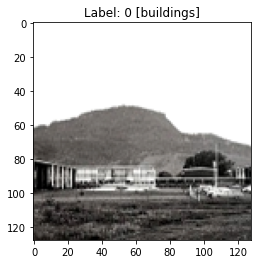

In [23]:
plot_image(*dataset[0])

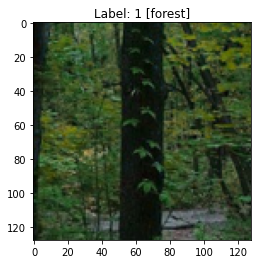

In [24]:
plot_image(*dataset[4282])

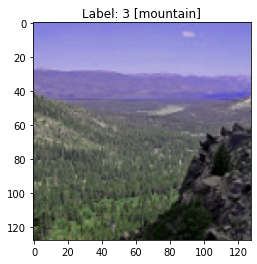

In [25]:
plot_image(*dataset[7935])

All the images are of the same size (128,128) because of the resizing of images. They all seem to look good so we do not need to do any data cleaning as of now. Although we might want to take a look at the images to check for any mislabeled images.

The images are pretty good for the human eye to identify as they have a descent resolution. We can check how the model performs on data of this image size and later compare it with different sizes. This can help us achieve higher accuracy or at least lower the training time. The batch size might also need to be altered to accommodate larger images.

We need to create a validation dataset also from the seg_test folder.

In [26]:
valid_dataset = ImageFolder(TEST_DIR, transform = valid_transforms)
valid_dataset.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

We can also look at some validation images, they'll look similar to train set.

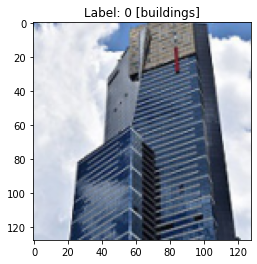

In [27]:
plot_image(*valid_dataset[0])

Let's create data loaders for both training and validation datasets to load data in batches. We use the DataLoader class for the task. We will also set a batch size of 64 for now.

In [28]:
batch_size = 64

* batch_size -- The batch_size can be doubled for validation as there's no gradient calculation and randomization.
* shuffle -- We need data to be shuffled at every epoch during training for generalization purposes.
* num_workers -- Number of subprocesses used for data loading.
* pin_memory -- Copy the tensors to CUDA pinned memory before returning.

In [29]:
train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size*2, num_workers=4, pin_memory=True)

Let's take a look at a batch of images at once as a grid by calling the make_grid function.

In [30]:
# helper function to take a batch of data and show grid of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

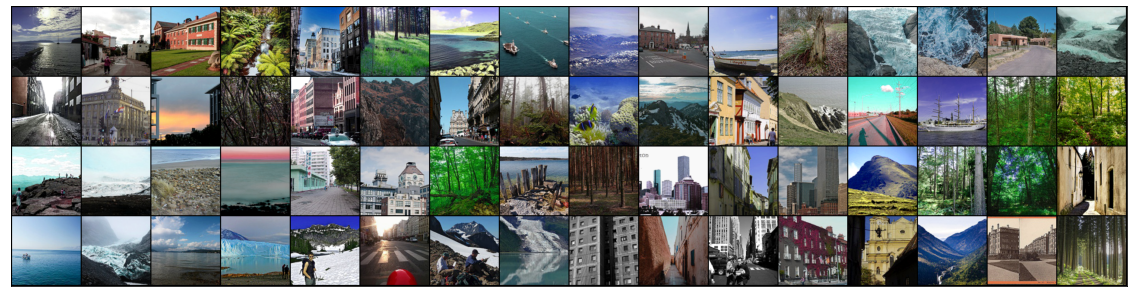

In [31]:
show_batch(train_dl)

Wow! That actually looks pretty cool. Some amazing pictures of nature and architecture packed into one grid. The images vary in color palette, contrast and even angles or perspective which might seem challenging for our model.

Okay, enough admiring the images. Let's get into the modeling, the most fun part of this project.

# Step - 4 : Modeling 

Let's start by creating a base model for Image Classification called ```ImageClassificationBase``` which will have functions for training and validation. The base model can be reused for other image classification problems too. We then write a custom model for Intel Image Classification, extending the base model.

We'll need the ```torch.nn``` module

In [32]:
class ImageClassificationBase(nn.Module):
    # Generate predictions and calculate loss
    def training_step(self, batch):
        images, labels = batch 
        out = self(images) 
        loss = F.cross_entropy(out, labels)
        return loss
        
    # Generate predictions and calculate loss & accuracy
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    # combine all the batch losses and accuracies
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    # print all the details for each epoch - train loss, valid loss and valid acc
    def epoch_end(self, epoch, result):
        print("Epoch [{}] | train_loss: {:.4f} | val_loss: {:.4f} | val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Let's use a pretrained model from ```torchvision.models```. We will use the ```ResNet34``` model and modify the last fully connected layer to output 6 probabilities as per our data.

Here's the network architecture of ResNet34.

![resnet](https://www.researchgate.net/profile/Aaron_Vose/publication/330400293/figure/fig6/AS:715395283558403@1547574935970/ResNet-neural-network-architecture-ResNet-34-pictured-image-from-11.ppm)


In [33]:
class IntelModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained = True):
        super().__init__()
        # instantiate a ResNet34 model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)
        
    def forward(self, xb):
        return self.network(xb)

In [34]:
model = IntelModel(num_classes = 6)
model

IntelModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

Let's quickly generate a batch of data and generate predictions. Also see the shape of input images and output tensor.

In [35]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 128, 128])
out.shape: torch.Size([64, 6])
out[0]: tensor([-1.1014, -1.2183,  0.2220, -0.6760, -1.2283,  1.0919],
       grad_fn=<SelectBackward>)


Now for faster training, we can use GPU. So we need to move the model and the data to GPU.

Let's write some helper functions for getting the default device and to move data to desired device. A ```DeviceDataLoader``` class to help us load a batch of data onto a device.

In [36]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')   

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Let's move our data and our model to GPU.

In [37]:
device = get_default_device()
device

device(type='cuda')

In [38]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
to_device(model, device)

IntelModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

We need some helper functions to fit our model and also evaluate. These functions can be reused later for other problems.

In [39]:
@torch.no_grad() # no gradient calculations 
def evaluate(model, val_loader):
    model.eval() # no randomization
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            # calculate loss
            loss = model.training_step(batch)
            train_losses.append(loss)
            # gradient calculation
            loss.backward()
            optimizer.step()
            # reset gradients
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [40]:
# create model
model = to_device(IntelModel(num_classes=6), device)

Let's evaluate our model once to check its validation accuracy and loss. Initially, the model will perform really bad because of the random weights assigned to it. After training for a few epochs, the model will learn the weights and will be able to classify images better.

In [41]:
# evaluate model
evaluate(model, valid_dl)

{'val_acc': 0.076171875, 'val_loss': 2.2787418365478516}

As expected, the model performs bad with about 18% accuracy. So lets train it to classify images using the fit function we wrote earlier.

Before training the model, we need to set a few hyperparameters for the training - **optimizer, learning rate and number of epochs**. Varying the hyperparameters can help us achieve great results.

We will log the hyperparameters using ```log_hyperparams``` function of jovian library to keep track of our experiments and choose the optimum values for our model.

In [42]:
# setting hyperparameters
num_epochs = [5,5]
opt_func = torch.optim.Adam
lr = [0.0005,0.0001]

In [43]:
# log hyperparameters
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [44]:
# fit the model
history = fit(num_epochs[0], lr[0], model, train_dl, valid_dl, opt_func)

Epoch [0] | train_loss: 0.3860 | val_loss: 0.3202 | val_acc: 0.8870
Epoch [1] | train_loss: 0.2639 | val_loss: 0.2509 | val_acc: 0.9114
Epoch [2] | train_loss: 0.2456 | val_loss: 0.2834 | val_acc: 0.9018
Epoch [3] | train_loss: 0.1981 | val_loss: 0.3081 | val_acc: 0.8944
Epoch [4] | train_loss: 0.1737 | val_loss: 0.2790 | val_acc: 0.9076


In [45]:
history += fit(num_epochs[1], lr[1], model, train_dl, valid_dl, opt_func)

Epoch [0] | train_loss: 0.0969 | val_loss: 0.2430 | val_acc: 0.9317
Epoch [1] | train_loss: 0.0612 | val_loss: 0.2583 | val_acc: 0.9256
Epoch [2] | train_loss: 0.0465 | val_loss: 0.3112 | val_acc: 0.9224
Epoch [3] | train_loss: 0.0321 | val_loss: 0.2859 | val_acc: 0.9268
Epoch [4] | train_loss: 0.0260 | val_loss: 0.3216 | val_acc: 0.9234


Let's also log the metrics - train_loss, val_loss and val_acc

In [46]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


# Step - 5 : Evaluation and Prediction

Let us again evaluate our model. This time it will perform much better.

In [47]:
evaluate(model, valid_dl)

{'val_acc': 0.9233630299568176, 'val_loss': 0.3215797543525696}

The model reached about 93% accuracy on the validation data.

We can generate plots for accuracy versus epoch and train_loss versus val_loss to see how our model is performing. We will write some helper functions to plot the graphs.

In [48]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [49]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

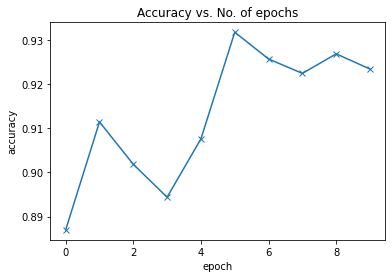

In [50]:
plot_accuracies(history)

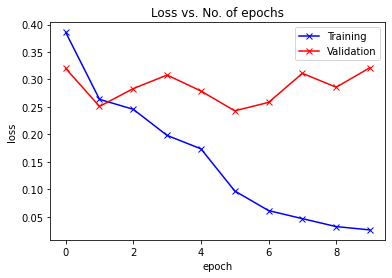

In [51]:
plot_losses(history)

After a few epochs, the training loss is decreasing but the validation loss remains constant and then starts increasing. This indicates overfitting. We can add normalizations, regularizations and also data augmentations to prevent overfitting.

### Helper functions for generating predictions

We will write a ```get_image_tensor``` function to convert the images to image tensors and then ```predict_image``` function to generate the predictions for the image.

In [52]:
def get_image_tensor(img_path):
  image = Image.open(img_path)
  image = valid_transforms(image)
  return image

In [53]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

### Prediction on validation images

Label: buildings , Predicted: buildings


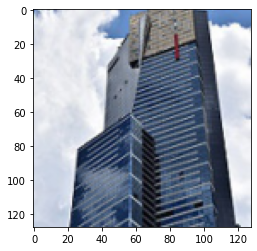

In [54]:
img1, label1 = valid_dataset[0]
plt.imshow(img1.permute(1, 2, 0))
print('Label:', dataset.classes[label1], ', Predicted:', predict_image(img1, model))

Label: forest , Predicted: forest


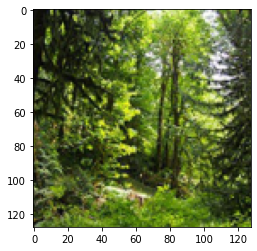

In [55]:
img2, label2 = valid_dataset[469]
plt.imshow(img2.permute(1, 2, 0))
print('Label:', dataset.classes[label2], ', Predicted:', predict_image(img2, model))

Label: mountain , Predicted: mountain


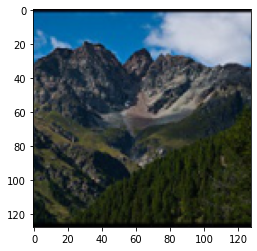

In [56]:
img3, label3 = valid_dataset[1533]
plt.imshow(img3.permute(1, 2, 0))
print('Label:', dataset.classes[label3], ', Predicted:', predict_image(img3, model))

### Predict for individual images in test
Let us now predict the classes for our test data in the **`seg_pred`** folder and **`PRED_DIR`** path which we set earlier to see how the model performs.

In [57]:
# get image file names
test_images = os.listdir(PRED_DIR)
print(len(test_images))
test_images[:5]


7301


['3049.jpg', '15337.jpg', '13889.jpg', '6165.jpg', '22910.jpg']

Let us generate predictions for the first 5 images in the test set and see if our model does a good job or not. We have to plot the images in order to check if the model's predictions are right. Since this was a competition, the test images do not have labels.

### Predict for first 5 images

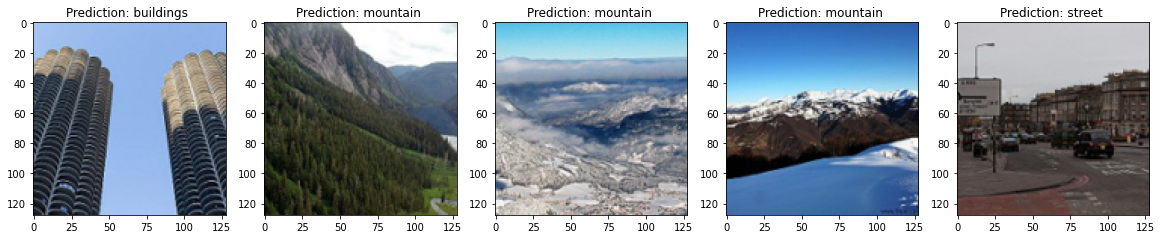

In [58]:
plt.figure(figsize = (20,20))
for i in range(5):
  image_tensor = get_image_tensor(os.path.join(PRED_DIR, test_images[i]))
  plt.subplot(1,5,i+1)
  # plot the image
  plt.imshow(image_tensor.permute(1, 2, 0))
  # get the prediction
  plt.title("Prediction: {} ".format(predict_image(image_tensor, model)));

The model seems to perform really well and is able to classify the images well. We can use another randomly seleccted sample to generate predictions to observe the performance of model. We will use the random module to generate a random sample of 10 images from the testset.

### Predict for 10 random images

In [59]:
# create a random sample set
sampleset = random.sample(test_images, 10)

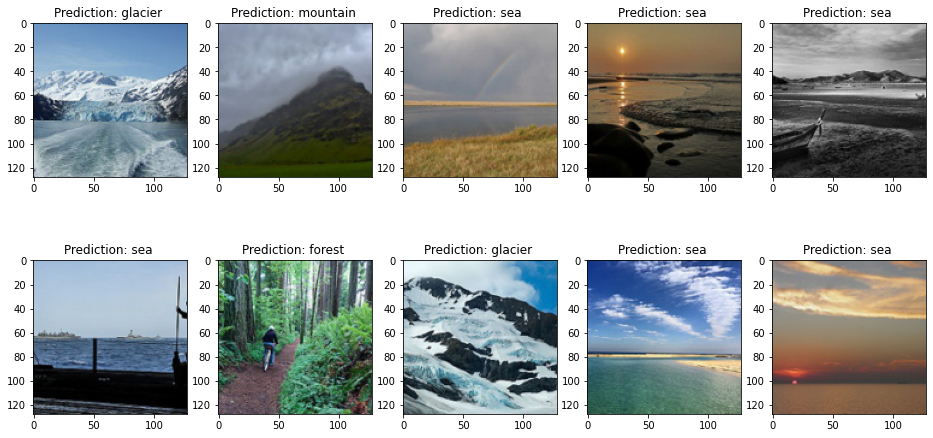

In [60]:
plt.figure(figsize = (16,8))
for i in range(10):
  image_tensor = get_image_tensor(os.path.join(PRED_DIR, sampleset[i]))
  plt.subplot(2,5,i+1)
  # plot the image
  plt.imshow(image_tensor.permute(1, 2, 0))
  # get the prediction
  plt.title("Prediction: {} ".format(predict_image(image_tensor, model)));

The model performs fairly well with most of the images. The last step would be to generate predictions for all the images in the testset and make a submission.

In [61]:
preds = []
for img in test_images:
    img_tensor = get_image_tensor(os.path.join(PRED_DIR, img))
    preds.append(predict_image(img_tensor,model))
preds[:10]

['buildings',
 'mountain',
 'mountain',
 'mountain',
 'street',
 'forest',
 'buildings',
 'mountain',
 'forest',
 'buildings']

Now we have generated predictions for test images and stored them in preds array. Our next step would be to create a data frame to store the image paths and the corresponding predicted label. Later we can save the dataframe as a ```submission.csv``` file for submitting to the competition.

In [62]:
sub = pd.DataFrame({'image_id': test_images, 'label': preds})
sub.head()

,image_id,label
0,3049.jpg,buildings
1,15337.jpg,mountain
2,13889.jpg,mountain
3,6165.jpg,mountain
4,22910.jpg,street


In [63]:
sub.to_csv("submission.csv", index=False)

After this, there should be a ```submission.csv``` file in our working directory consisting of all the predictions.

# Step - 6 : Improvement

### Analysis of model hyperparameters and network architecture along with their corresponding metrics.
1. Baseline Model | 3-layer-CNN  
  - 80% accuracy
  - 64 batch_size, 10 epochs, 0.001 lr

The baseline model performs fairly well. We can try using pretrained models for better accuracy.

2. ResNet34 Model 
  - 89% accuracy
  - 64 batch_size, 5 + 5 epochs, 0.001 + 0.0005 lr

The models seems to bounce around the minima looking at the loss vs epochs and accuracy vs epochs graphs. We can reduce the lr and train to achieve better results.

3. ResNet34 Model + Augmentations
  - 93% accuracy
  - 64 batch_size, 5 + 5 epochs, 0.0005 + 0.0001 lr

As observed, adding a few image augmentations and lowering down the learning rate helps achieve a higher accuracy.

# Step - 7 : Conclusion and Future work

The project presents an interactive notebook to classify images of nature scenes of 6 different categories with **Transfer learning in PyTorch** using the **Intel Image Classification** dataset. The final model achieved an accuracy of about **93%**. The project has many base functions and reusable code to aid in other deep learning problems.

Further Improvements:
1. Try out other pretrained models
2. Play around with the hyperparameters.
3. Collect more data
4. Different libraries (Keras, Tensorflow)

A huge thank you to **Jovian** and **FreeCodeCamp** for such an amazing course. The [Deep Learning with PyTorch - Zero to GANS](https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans) course did teach me a lot about writing clean and reusable deep learning functions. Deep learning is a vast subject and we must keep learning to get better and better.

References:
* Course page: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans
* Dataset: https://www.kaggle.com/puneet6060/intel-image-classification
* PyTorch Documentation for transforms: https://pytorch.org/docs/stable/torchvision/transforms.html



In [ ]:
jovian.commit(project = project_name)